## 0. Import some necessary modules

In [26]:
from pickle import load
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from pickle import load, dump, HIGHEST_PROTOCOL
import xgboost as xgb
from sklearn.decomposition import PCA
import os
%matplotlib inline

## 1. Find out the easily confusable categories for each category based on the predictions of the fine-tuned mode in stage I on both training and test sets
### 1.1 Load the necessary data previously saved in the stage I

In [44]:
# Load the true labels for the images of training and test sets
with open('datasets/train_i1.pickle', 'rb') as f:
    train_set = np.array(load(f))  
with open('datasets/valid_i1.pickle', 'rb') as f:
    valid_set = np.array(load(f))

labels_train = train_set[:,1].astype('int')
labels_valid = valid_set[:,1].astype('int')

In [45]:
# Load the predicted labels for the images of training and test sets
with open('prediction/fine3_train.pickle', 'rb') as f:
    predictions_train = np.array(load(f))
with open('prediction/fine3_valid.pickle', 'rb') as f:
    predictions_valid = np.array(load(f))

### 1.2 Calculate the confusion matrix for both the training and validation set respectively and then merge them into a total confusion matrix

In [46]:
from collections import Counter

matrix_train = []
for category in tqdm(range(5270)):
    entry = []
    indices = [i for i, j in enumerate(predictions_train) if j == category ]
    c = Counter(labels_train[indices]) 
    total_n = len(indices)
    for cate in range(5270):
        if cate not in c.keys():
            entry.append(0)
        else:
            entry.append(c[cate])
    matrix_train.append(entry)
matrix_train = np.array(matrix_train)

matrix_valid = []
for category in tqdm(range(5270)):
    entry = []
    indices = [i for i, j in enumerate(predictions_valid) if j == category ]
    c = Counter(labels_valid[indices]) 
    total_n = len(indices)
    for cate in range(5270):
        if cate not in c.keys():
            entry.append(0)
        else:
            entry.append(c[cate])
    matrix_valid.append(entry)
matrix_valid = np.array(matrix_valid)
    

100%|██████████| 5270/5270 [01:45<00:00, 49.82it/s]


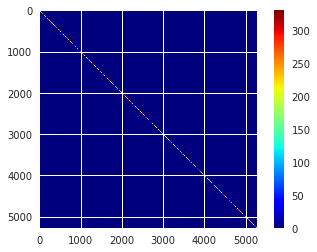

In [49]:
# Merge the two confusiong matrix
matrix_total = matrix_train + matrix_valid

# Visualize the total confusiong matrix
plt.imshow(matrix_total, cmap='jet')
plt.colorbar()

### 1.3 Condense the confusion matrix

In [50]:
# For each category, list the indices of all its true and false negative categories 
# as well as their number of occurance in the training and testing sets
matrix_total_c = []
for i in matrix_total:
    item = [[ind, j] for ind, j in enumerate(i) if j] # [..., [index_category_i, number of counts], ...]
    matrix_total_c.append(item)

In [51]:
# Example: true and false categories for category 1340
item = matrix_total_c[1340]
pprint(sorted(item, key=lambda x: x[1], reverse=True))

[[1340, 244],
 [1844, 6],
 [1330, 4],
 [177, 3],
 [1302, 2],
 [67, 1],
 [99, 1],
 [284, 1],
 [355, 1],
 [665, 1],
 [931, 1],
 [1090, 1],
 [1112, 1],
 [1117, 1],
 [1177, 1],
 [1200, 1],
 [1219, 1],
 [1224, 1],
 [1260, 1],
 [1322, 1],
 [1338, 1],
 [1395, 1],
 [1633, 1],
 [1763, 1],
 [1806, 1],
 [1845, 1],
 [2412, 1],
 [2555, 1],
 [2743, 1],
 [2796, 1],
 [2805, 1],
 [2811, 1],
 [2887, 1],
 [3488, 1],
 [3548, 1],
 [3934, 1],
 [4061, 1]]


Totally in the training and the validation set, the category 0 was successfully identified for 21 times but was wrongly recognized as the category 3195 for 2 times, as the category 3206 for 2 times, as the category 461 for 1 time and so on.

### 1.4 Identify the easily confusable categories 

In [85]:
subsets = {} # the keys are the indices of categories from 0 to 5269, the values are lists that contain the categories themself and their corresponding easily confusable categories

# If category_m is misclassified as category_n for more than one times in the training and test set
# category_m will be added to the list of easily confusable categories of category_n located at subsets[category_n]:
for i in range(5270):
    confusions = matrix_total_c[i]
    if len(confusions)>1: 
        subsets[i] = [n[0] for n in confusions if n[1] > 1]
        if len(subsets[i]) < 2:
            subsets[i] = None
    else:
        subsets[i] =  None

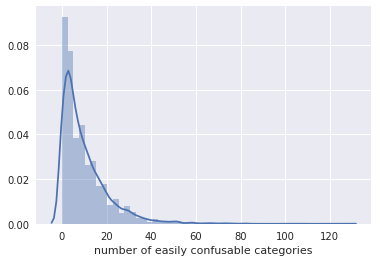

In [78]:
# Calculate the number of easily confusable categories for each category
matrix_len = pd.Series([len(subsets[k]) if isinstance(subsets[k], list) else 0 for k in subsets.keys()], name="number of easily confusable categories")

# Visualize the distribution of the number of easily confusable categories across
sns.distplot(matrix_len)

## 2. Train the sets of xgboost classifiers for each category among its easily confusable categories
### 2.1 Load the previously calculated bottleneck features

In [11]:
from pickle import load

with open('bnfeature/train_fine_3fs.pickle', 'rb') as f:
    bnf_train = load(f)

### 2.2 Tune and setup the hyper-parameters for training the xgboost classifiers
#### 2.2a Tune the hyper-parameters

In [1]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

seed = 42
params_grid = dict(max_depth=[1,2,3], n_estimators=[5,10,25,50], learning_rate=[0.1,0.3,0.9])

params_fixed = dict(objective='multi:softmax', silent=1)
bst_grid = GridSearchCV(estimator=XGBClassifier(**params_fixed, seed=seed),
                       param_grid=param_grid)

In [ ]:
# The hyper-parameter tuning will be performed on a reduced training set
# which consists of all the training samples from category 0 and those from
# the easily confusable categories of category 0


cat_tune = 0
cats = subsets[cat_tune] # Category 0 and its easily confusable categories
train_x, train_y= [], []

# Establish the reduced training set to discriminate category 0 and 
# its easily confusable categories

for nr, cat in enumerate(cats):
    bnf_sec = bnf_train[cat]
    bnf_sec = [list(bnf) for bnf in bnf_sec]
    train_x+=(bnf_sec)
    train_y+=[nr]*len(bnf_sec)

train_x = np.array(train_x)
train_y = np.array(train_y)  

xg_train = xgb.DMatrix(train_x, label=train_y)

In [ ]:
bst_grid.fit(train_x, train_y)

#### 2.2b Use the tuned hyper-parameters

In [12]:
param = {}

param['objective'] = 'multi:softmax'
param['eta'] = 0.3
param['max_depth'] = 3
param['silent'] = 1
param['tree_method'] = 'auto'

### 2.3 Train the sets of XGBoost classifiers

In [ ]:
from random import shuffle
from sklearn.decomposition import PCA

cats_total = 5270 # train a xgboost classifier for each category
batch_size = 50 # organize the training process in batches of 50 categories
batch_n = int(np.ceil(cats_total/batch_size)) # total number of batches

for m in tqdm(range(0, batch_n)):
    classifiers = []  
    begin = m*batch_size
    if m == batch_n-1:
        end = 5270
    else:
        end = (m+1)*batch_size
    for i in range(begin, end):
        print("Train the classifier for category %d" % i)
        # Get the list that includes category i and its easy confusable categories
        cats = subsets[i] 

        if isinstance(cats,list):
            train_x, train_y= [], []
            
            # To establish a reduced training set for each category,
            # where only the training samples from this category
            for nr, cat in enumerate(cats):
                bnf_sec = bnf_train[cat]
                bnf_sec = [list(bnf) for bnf in bnf_sec]
                train_x+=(bnf_sec)
                train_y+=[nr]*len(bnf_sec)

            train_x = np.array(train_x)
            train_y = np.array(train_y)  
   
            xg_train = xgb.DMatrix(train_x, label=train_y)

            num_round = 50
            param['num_class'] = len(cats)

            bst = xgb.train(param, xg_train, num_round)
            
            item = {} 
            item['cats'] = cats 
            item['clf'] = bst
            classifiers.append(item)

            classifiers.append(classifiers[cats])
        else:
            classifiers.append(None)
    
    # Save the trained classifiers periodically to prevent data loss due to expected interruptions
    with open("classifiers/classifier_batch_%d" %m, 'wb') as f:
        dump(classifiers, f, HIGHEST_PROTOCOL)

## 3. Connect the stage II classifiers with the previously trained ResNet50 model to make predictions
### 3.1 Load the previously trained ResNet50 model

In [2]:
from keras.models import load_model

model = load_model('weights/fullmodel.best.fine3.hdf5')

Using TensorFlow backend.
/home/jin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 3.2 Configurate the model so that it will output both the bottleneck features and the probabilities for each category

In [4]:
from keras.models import Model
output = [model.layers[-2].output, model.output]
model1 = Model(input=model.input, output=output)

/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


### 3.3 Prepare the interface that reads image files into the corresponding matrices of pixel values

In [11]:
from keras.preprocessing import image  
import numpy as np


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))

    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)



### 3.4 Implement the two-stage classification methodology, which refines the prediction of the stage I ResNet50 model by a subsequent XGBoost based classification

In [3]:
from keras.applications.resnet50 import preprocess_input
def predict(paths, model1, model2,  batch_size=1000, batch_step=-1, save=True, restart=False):
    """Predict the category of a product based its images, by implementing the two-stage classification methodology,
    which refines the prediction of the stage I ResNet50 model by a subsequent XGBoost based classification
    
    # Arguments
        paths: the list that contains the paths of the images to be classified
        model1: the previously trained and fine-tuned ResNet50 model in stage I
        model2: the list of the previously trained stage II XGBoost classifiers for each category
        batch_size: batch size of image matrices for the stage I classification based on the ResNet50 model
        batch_step: the number of batches of the stage I classification, after which the stage II classification based on XGBoost will be performed;
                    batch_step = -1 means that stage II classification starts only after the completion of stage I classification on the whole test set
        save: save the predicted categories and the calculated bottleneck features during the stage I classification
        restart: only perform the stage II classification on the precondition that the calculation in the previous stage I classification 
                 has been successfully saved (save=True).
                 
    # Returns  
        a list of predicted categories (indices)           
    
    """
    n_batches = int(np.ceil(len(paths)/batch_size))
    predictions = []

    bnfs_ac = []
    predictions_ac =[]
    predictions_probs_ac = []
    for n in tqdm(range(n_batches)):
        
        flag = 1
        if restart:
            if batch_step == -1:
                if os.path.exists('prediction/predictions_ac.pickle') and os.path.exists('prediction/bnfs_ac.pickle'): 
                    flag = 0
            else:
                if os.path.exists('prediction/predictions_ac_%d.pickle' % int((n+1)/batch_step))\
                    and os.path.exists('prediction/bnfs_ac_%d.pickle' % int((n+1)/batch_step)):
                    flag =0                                     
        if flag:
            if n != n_batches-1:
                paths_n = paths[n*batch_size:(n+1)*batch_size]
            else:
                paths_n = paths[n*batch_size:]
            X = paths_to_tensor(paths_n)
            bnf, predictions_probs = model1.predict(preprocess_input(X))
            predictions_1 = list(np.argmax(predictions_probs, axis=1))
            predictions_ac += predictions_1
            predictions_probs_ac += predictions_probs.tolist()
            bnfs_ac += list(bnf)
                                       
        flag = 0
        if batch_step == -1:
            if n == n_batches-1:
                flag = 1
        elif (n+1)% batch_step == 0:
            flag = 1
        if flag == 1:
            if restart:
                if batch_step == -1:
                    filename_prediction = 'prediction/predictions_ac.pickle'
                    filename_bnf = 'prediction/bnfs_ac.pickle'
                else:
                    filename_prediction = 'predicion/predictions_ac_%d.pickle' % int((n+1)/batch_step)
                    filename_bnf = 'prediction/bnfs_ac_%d.pickle' % int((n+1)/batch_step)
                with open(filename_prediction, 'rb') as f:
                    predictions_ac = load(f)
                with open(filename_bnf, 'rb') as f:
                    bnfs_ac = load(f)
            elif save:
                if batch_step == -1:
                    filename_prediction = 'prediction/predictions_ac.pickle'
                    filename_prediction_probs = 'prediction/predictions_probs_ac.pickle'
                    filename_bnf = 'prediction/bnfs_ac.pickle'
                else:
                    filename_prediction = 'prediction/predictions_ac_%d.pickle' % int((n+1)/batch_step)
                    filename_prediction_probs = 'prediction/predictions_probs_ac_%d.pickle' % int((n+1)/batch_step)
                    filename_bnf = 'prediction/bnfs_ac_%d.pickle' % int((n+1)/batch_step)
                with open(filename_prediction, 'wb') as f:
                    dump(predictions_ac,f, HIGHEST_PROTOCOL)
                with open(filename_prediction_probs, 'wb') as f:
                    dump(predictions_probs_ac,f, HIGHEST_PROTOCOL)
                with open(filename_bnf, 'wb') as f:
                    dump(bnfs_ac,f, HIGHEST_PROTOCOL)
            section = {}
            for i, bnf in enumerate(bnfs_ac):
                cat = predictions_ac[i]
                if cat not in section.keys():
                    section[cat] = []
                section[cat].append([bnf.tolist(), i])
                
            predictions_ = [0]*len(bnfs_ac)
            for cat in section.keys():
                data = list(zip(*section[cat]))
                
                X = np.array(data[0]).reshape(len(data[0]),2048)
                indices = data[1]
                if model2[cat]:
                    cats = model2[cat]['cats']
                    clf = model2[cat]['clf']
                    X = xgb.DMatrix(X)
                    pred_label = clf.predict(X).astype('int')
                    for j in range(len(data[0])):
                        predictions_[indices[j]] = cats[pred_label[j]]
                else:
                    for j in range(len(data[0])):
                        predictions_[indices[j]] = cat
            bnfs_ac = []
            predictions_ac = []
            predictions += predictions_

    return np.array(predictions)

Using TensorFlow backend.
/home/jin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 3.5 Test the performance of this combined model (stage I + stage II) on the test set

In [7]:
with open('datasets/test_i1.pickle', 'rb') as f:
    test_set = np.array(load(f))

features, labels = test_set[:,0], test_set[:,1]
labels= labels.astype('int')
predictions = predict(features, None, classifiers, batch_size = 1000, batch_step=-1, restart=True)

100%|██████████| 129/129 [00:22<00:00,  5.84it/s]


In [49]:
print('accuracy: ', sum(predictions == labels)/len(labels))

accuracy:  0.44353504775
